# 1. Data Load

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## 1.1 Charging Stations

In [2]:
# load charging station data from opendata portal of Rhein-Kreis-Neuss found via govdata.de
stations_raw = pd.read_csv("https://opendata.rhein-kreis-neuss.de/explore/dataset/rhein-kreis-neuss-ladesaulen-in-deutschland/download/?format=csv",
                           dtype = {"betreiber": str,
                                    "anzahl_ladepunkte": int,
                                    "anschlussleistung": float,
                                    "steckertypen1": str,
                                    "steckertypen2": str,
                                    "steckertypen3": str,
                                    "steckertypen4": str,
                                    "p1_kw": float,
                                    "p2_kw": float,
                                    "p3_kw": float,
                                    "p4_kw": float,
                                    "kreis_kreisfreie_stadt": str,
                                    "ort": str,
                                    "postleitzahl": str,
                                    "strasse": str,
                                    "hausnummer": str,
                                    "adresszusatz": str,
                                    "koordinaten": str,
                                    "normalladeeinrichtung": str},
                           quotechar = '"',
                           sep = ";",
                           parse_dates = ["inbetriebnahmedatum"])

## 1.2 Registered Vehicles

In [3]:
# load vehicle registration data from opendata portal from Kraftfahrtbundesamt
vehicles_raw = pd.read_excel("https://www.kba.de/SharedDocs/Downloads/DE/Statistik/Fahrzeuge/FZ3/fz3_2022.xlsx?__blob=publicationFile&v=3", sheet_name = "FZ 3.1")

## 1.3 Mapping Data: PLZ to Administrative Region

In [4]:
# load mapping data linking PLZ and Administrative Region
mapping_raw = pd.read_csv("https://downloads.suche-postleitzahl.org/v2/public/zuordnung_plz_ort.csv",
                          sep = ",",
                          dtype = {"osm_id": str,
                                   "ags": str,
                                   "ort": str,
                                   "plz": str,
                                   "landkreis": str,
                                   "bundesland": str})

## 1.4 Second-level Administrative Divisions, Germany, 2015

In [5]:
# read geojson file containing district shapes
# see README file in data folder for further explanation on the implementation of the data load
try:
    districts = gpd.read_file("https://geodata.lib.berkeley.edu/download/file/stanford-nz271ny2119-geojson.json")
except:
    districts = gpd.read_file("data/stanford-nz271ny2119-geojson.json")

# 2. Data Cleaning

This chapter outlines the steps taken in order to bring the raw data into a usable format given the context of the application.

## 2.1 Charging Stations

The charging stations dataset is available as a csv file. However, as there is one free text column (additional_address) containing quotation marks, linebreaks and other text formatting, the dataset has to be loaded row by row. As stated in the data description, only the number of stations and the zip code of the station are relevant to this application. All other columns are dropped.

In [6]:
# copy raw data to working df
stations = stations_raw.copy()

# replace column names with english names
stations.columns = ["owner",
                    "type",
                    "count",
                    "connected_load",
                    "connector_1",
                    "connector_2",
                    "connector_3",
                    "connector_4",
                    "p1",
                    "p2",
                    "p3",
                    "p4",
                    "district",
                    "municipality",
                    "zip",
                    "street_name",
                    "street_number",
                    "additional_address",
                    "installation_date",
                    "coordinates"]

# drop irrelevant columns
stations = stations.drop(["owner", "connected_load", "connector_1", "connector_2", "connector_3", "connector_4", "p1", "p2", "p3", "p4", "district", "additional_address", "coordinates"], axis = 1)

# summarize data into stations_summary
stations_summary = stations.groupby("zip").agg({"count": "sum"})

# convert index to column
stations_summary["zip"] = stations_summary.index

# rename and reset index
stations_summary.index.names = ["index"]
stations_summary = stations_summary.reset_index(drop = True)

## 2.2 Registered Vehicles

The registered vehicles dataset is available as xls file. This file contains information about registered motorcycles, trucks, tractors, busses and trailers as well. These columns are dropped as the application focuses on cars only, as only these are used for charging at the publicly available charging stations. The file contains a blank column on the left, a few columns on top containing additional information not relevant to the application and another few columns at the bottom summarizing the dataset. All of these columns and rows are dropped. There are summary rows throughout the file as well, which are removed. Also, there are merged cells in this file which produces a lot of NaN values in the columns state & district. These are filled with the correct value, before performing further cleaning steps.

In [7]:
# copy raw data to working df
vehicles = vehicles_raw.copy()

# remove empty first column
vehicles.drop(vehicles.columns[0], axis = 1, inplace = True)

# drop first rows containing no usable data
vehicles.drop(vehicles.index[0:8], axis = 0, inplace = True)

# drop last rows containing no usable data
vehicles.drop([11209, 11210, 11211, 11212, 11213, 11214, 11215 ,11216, 11217, 11218, 11219],
              axis = "index",
              inplace = True)

# reset index
vehicles.reset_index(drop = True, inplace = True)

# assign proper english column names
vehicles.columns = ["state",
                    "district_raw",
                    "municipality",
                    "motorcycles",
                    "cars_total",
                    "cars_business",
                    "trucks",
                    "tractors_total",
                    "tractors_agri_forest",
                    "other_vehicles_buses",
                    "vehicles_total",
                    "trailers"]

# drop irrelevant columns
vehicles.drop(["motorcycles",
               "cars_business",
               "trucks",
               "tractors_total",
               "tractors_agri_forest",
               "other_vehicles_buses",
               "vehicles_total",
               "trailers" ],
              axis = 1,
              inplace = True)

# fill NaN values
# replace in these columns
for column in ["state", "district_raw"]:
    # loop through all the rows
    for row in range(0,len(vehicles)):
        # check if value is NaN
        if vehicles.iloc[row][column] != vehicles.iloc[row][column]:
            # replace with value from previous row if NaN
            vehicles.iloc[row][column] = vehicles.iloc[row-1][column]

# remove summary rows
# create list to store row indexes to be dropped
drop = []

# define column to be searched
column = "municipality"

# loop through all the rows and append row index do drop list
for row in range(0, len(vehicles)):
    # check if row is summary row
    if vehicles.iloc[row][column] == "ZUSAMMEN":
        # append to list to be dropped later
        drop.append(row)

# define column to be searched
column = "state"

# loop through all the rows and append row index do drop list
for row in range(0, len(vehicles)):
    # check if row is summary row
    if "INSGESAMT" in vehicles.iloc[row][column]:
        # append to list to be dropped later
        drop.append(row)

# iterate through droppable list and execute drop
for row in drop:
    vehicles.drop([row], axis = "index", inplace = True)

# reset index
vehicles.reset_index(drop = True, inplace = True)

# fix values mismatching shape file (Trier & Eisenach)
# see methodic_procedure.md for further information
vehicles.loc[vehicles["municipality"] == "54290  TRIER,ST.", "district_raw"] = "TRIER (07235)"
vehicles.loc[vehicles["municipality"] == "99817  Eisenach, Stadt", "district_raw"] = "EISENACH (16056)"

# extract district id & district id
vehicles["district_id"] = vehicles["district_raw"].str[-8:].str[2:7]
vehicles["district"] = vehicles["district_raw"].str[:-8]

# drop irrelevant columns
vehicles.drop(["state",
               "municipality",
               "district_raw",
               "district"],
              axis = 1,
              inplace = True)

# reorder columns
vehicles = vehicles[["district_id", "cars_total"]]

# replace "." & "-" value with 0
vehicles.loc[vehicles["cars_total"] == ".", "cars_total"] = 0
vehicles.loc[vehicles["cars_total"] == "-", "cars_total"] = 0

# assign correct column types
vehicles = vehicles.astype({"district_id": str, "cars_total": int})

# summarize number of cars per district_id
vehicles = vehicles.groupby("district_id").agg({"cars_total": "sum"})

# convert index to column
vehicles["district_id"] = vehicles.index

# rename and reset index
vehicles.index.names = ["index"]
vehicles = vehicles.reset_index(drop = True)

## 2.3 Mapping Data: PLZ to Administrative Region

This dataset has tidy data in a csv format. The required columns are district_id and the zip code. The district_id is available on municipality level and has to be stripped of its last 3 digits to get the district_id.

In [8]:
# copy raw data to working df
mapping = mapping_raw.copy()

# assign proper column names
mapping.columns =["osm_id","district_id","city","zip","district","state"]

# drop irrelevant columns
mapping.drop(["osm_id", "city", "district", "state"], axis = 1, inplace = True)

# fix values mismatching shape file (Eisenach)
# see methodic_procedure.md for further information
mapping.loc[mapping["zip"] == "99817", "district_id"] = "16056000"

# strip last 3 digits of ags code
mapping["district_id"] = mapping["district_id"].str[:-3]

# remove duplicates created by truncation of district_id
mapping.drop_duplicates(inplace = True)

## 2.4 Second-level Administrative Divisions

In [9]:
# fix values mismatching vehicle & station data (Göttingen & Osterode am Harz)
# see methodic_procedure.md for further information
districts.loc[districts["cca_2"] == "03152", "cca_2"] = "03159"
districts.loc[districts["cca_2"] == "03156", "cca_2"] = "03159"

# 3. Data Merge

In [10]:
# join mapping data with stations_summary using zip
result = pd.merge(mapping, stations_summary, on = "zip", how = "left")

# summarize on district level
result = result.groupby(["district_id"]).agg({"count": "sum"})

# join with vehicle data using district_id
result = pd.merge(result, vehicles, on = "district_id", how = "left")

# 4. KPI Computation

In [11]:
# calculate number of stations per 1000 cars per district
result["stations_per_1000_cars"] = round(result["count"]/(result["cars_total"]/1000),2)

# 5. Visualization

This chapter outlines the steps taken in order to visualize the KPI calculated above.

## 5.1 Visualization Preparation

In [12]:
# add KPI to districts data frame
districts = pd.merge(districts, result, left_on = "cca_2", right_on = "district_id", how = "left")

## 5.2 Visualization Creation

Visualization successfully generated:


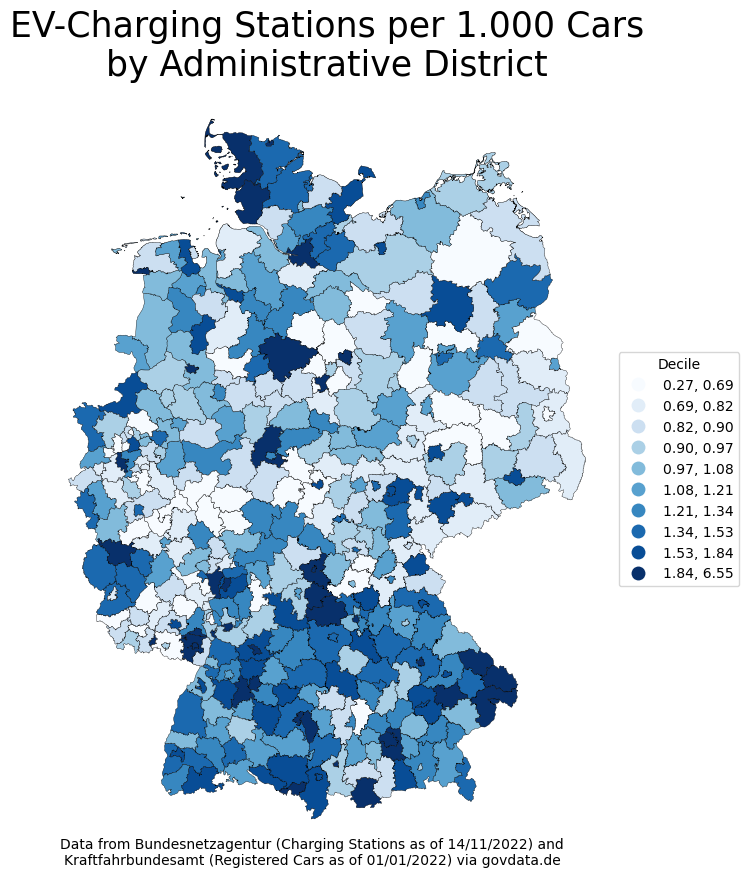

In [13]:
# the following tutorials were used to create the first iterations of the visualization:
# - https://geopandas.org/en/stable/docs/user_guide/mapping.html
# - https://www.youtube.com/watch?v=Q0z1cPD_7yE
# - https://www.youtube.com/watch?v=t7lliJXFt8w&t=2497s
# - https://www.youtube.com/watch?v=L28-l516kQo&t=393s
# - https://www.youtube.com/watch?v=5G-1k4CNChI&t=563s

# define chart configuration
fig, ax = plt.subplots(figsize = (12, 10), subplot_kw = dict(aspect = "equal"))

# add plot
districts.plot(column = "stations_per_1000_cars",
               ax = ax,
               # apply classification scheme
               scheme = "quantiles",
               # apply split into 10 buckets to classification
               k = 10,
               # select color schema
               cmap = "Blues",
               # set legend to "on"
               legend = True,
               # configure legend
               legend_kwds = {'loc': 'center left',
                              "title": "Decile",
                              'bbox_to_anchor':(1, 0.5)},
               # configure polygon border lines
               edgecolor = "black",
               linewidth = 0.25)

# remove gridlines
plt.axis('off')
# add title
plt.title("EV-Charging Stations per 1.000 Cars\nby Administrative District", fontdict = {"fontsize": 25})

# add caption
plt.figtext(0.5, 0.1, "Data from Bundesnetzagentur (Charging Stations as of 14/11/2022) and\nKraftfahrbundesamt (Registered Cars as of 01/01/2022) via govdata.de", horizontalalignment = 'center', fontsize = 10)

# report successful visualization
print("Visualization successfully generated:")